In [1]:
import pandas as pd
pd.set_option('display.max_rows', 999)
pd.options.plotting.backend = "plotly"

import matplotlib.pyplot as plt
import re
import numpy as np
import unicodedata

In [2]:
def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

In [3]:
PATH_TO_WOF_STATS = "../parser/data/wof_stats.csv"

In [4]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(PATH_TO_WOF_STATS, header=0)
df["Date"] = pd.to_datetime(df['Date'])
df["Date"] = df["Date"].dt.round("15min")

In [5]:
studios = df["Studio"].unique()

In [6]:
def show_and_save_global_allocation_for_studio(df, studio):
    df_studio = df[df['Studio'] == studio].copy()
    
    fig = df_studio.plot(x='Date', y='NumAllocatedLockers')
    fig.update_layout(title_text=f"Number of allocated lockers in studio '{studio}'")
    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='Number of allocated lockers')
    fig.update_yaxes(ticksuffix="%")
    fig.show()
    
    fig.write_image(f"./figures/{slugify(studio)}_complete.png", width=2000, height=500, scale=2)

In [7]:
def show_and_save_weekly_plot_for_studio(df, studio):
    df_studio = df[df['Studio'] == studio].copy()
    df_studio["Weekday"] = df_studio['Date'].dt.day_name()
    df_studio["Hour"] = df_studio['Date'].dt.hour
    df_studio.sort_values(by=['Weekday', 'Hour'], inplace=True)
    df_studio_avg_per_weekday = df_studio.groupby(["Weekday", "Hour"])['NumAllocatedLockers'].mean()
    df_studio_avg_per_weekday = df_studio_avg_per_weekday.reset_index(level=0)

    fig = df_studio_avg_per_weekday.plot(x=df_studio_avg_per_weekday.index, y='NumAllocatedLockers', facet_col='Weekday', category_orders={'Weekday': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})
    fig.update_xaxes(type='category', categoryarray=[str(h) for h in range(0, 24 + 1)])
    fig.update_layout(
        title=f"% of allocated lockers per hour and weekday for studio '{studio}'",
        xaxis_title="Hour",
        yaxis_title="% of allocated lockers",
        legend_title="Weekday",
    )
    fig.update_yaxes(ticksuffix="%")

    fig.show()
    fig.write_image(f"./figures/{slugify(studio)}_weekday.png", width=2000, height=500, scale=2)

In [83]:
# show_and_save_global_allocation_for_studio(df, "WOF PUR - Aachen")
show_and_save_weekly_plot_for_studio(df, "WOF PUR - Aachen")

In [84]:
# show_and_save_global_allocation_for_studio(df, "WOF 22 - Fitness für die Frau")
show_and_save_weekly_plot_for_studio(df, "WOF 22 - Fitness für die Frau")

In [85]:
# show_and_save_global_allocation_for_studio(df, "WOF 1 - Aachen Zentrum")
show_and_save_weekly_plot_for_studio(df, "WOF 1 - Aachen Zentrum")

In [86]:
# show_and_save_global_allocation_for_studio(df, "WOF 3 - Aachen West")
show_and_save_weekly_plot_for_studio(df, "WOF 3 - Aachen West")

In [89]:
# show_and_save_global_allocation_for_studio(df, "WOF PUR - Euskirchen")
show_and_save_weekly_plot_for_studio(df, "WOF PUR - Euskirchen")

In [91]:
show_and_save_weekly_plot_for_studio(df, "WOF 4 - Aachen Brand")

# ARIMA

In [8]:
df_wof_aachen_pur = df[df['Studio'] == 'WOF PUR - Aachen']

/var/folders/27/35dp_qr520d9ff2lr528z6380000gn/T/ipykernel_13253/1819990709.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x / (24 * 4)) for x in ax.get_xticks()])


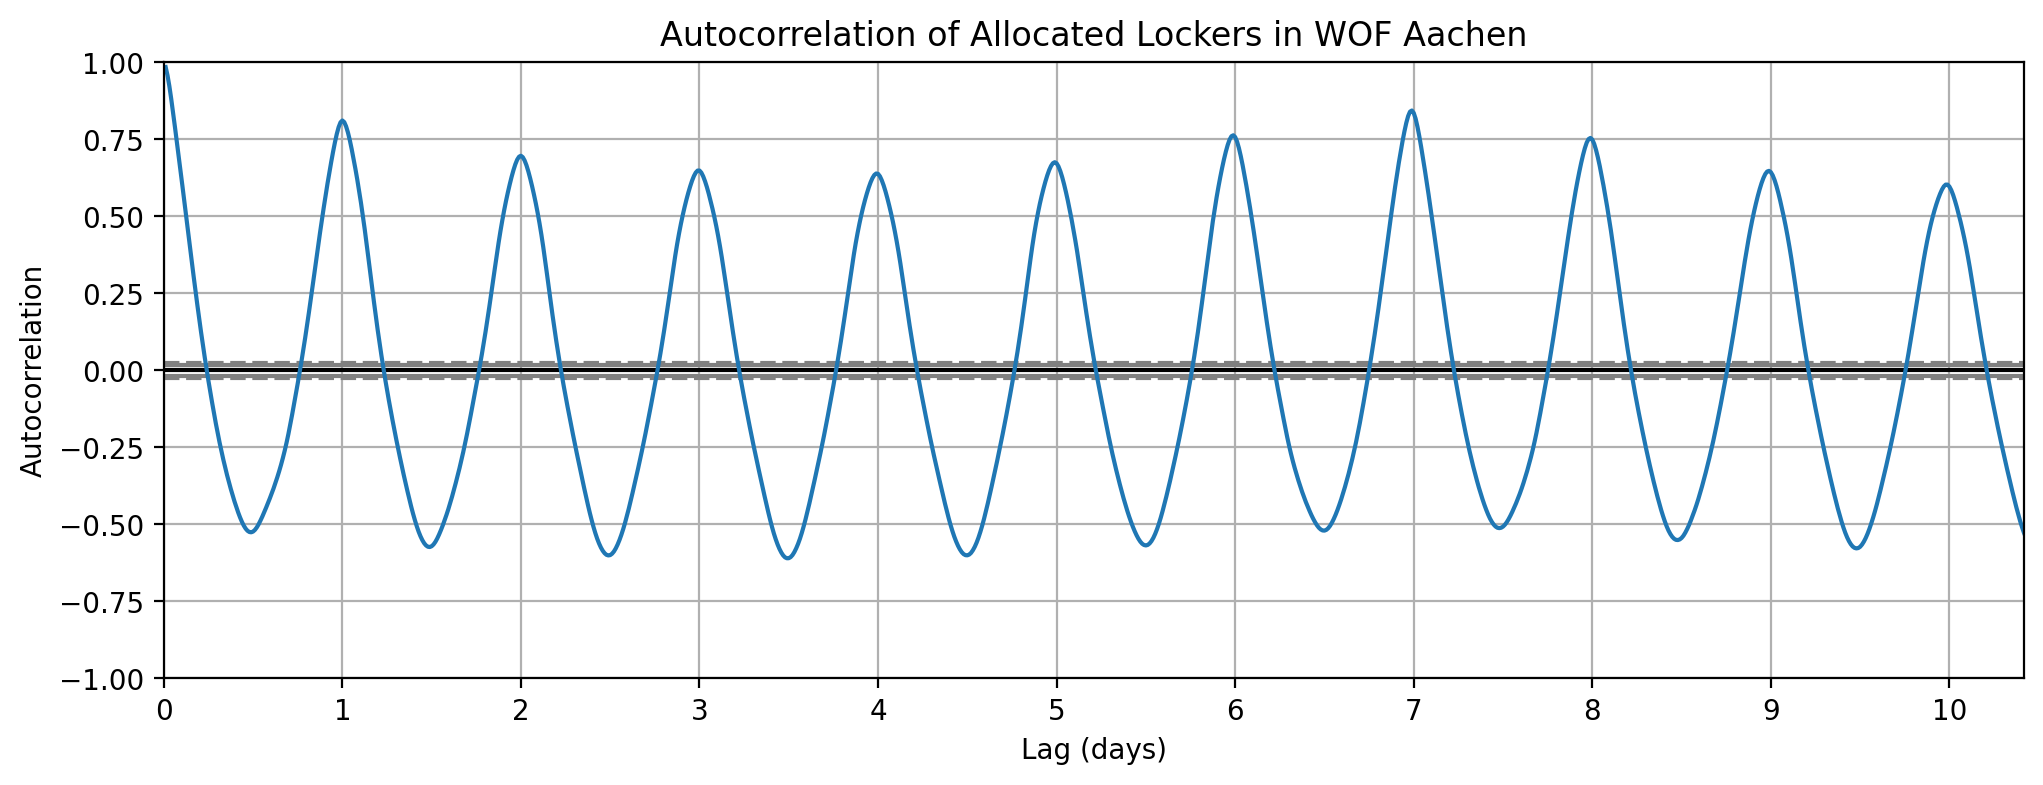

In [9]:
from pandas.plotting import autocorrelation_plot
from matplotlib.ticker import MultipleLocator

ax = autocorrelation_plot(df_wof_aachen_pur['NumAllocatedLockers'])
ax.set_xlim([0, 1000])
ax.xaxis.set_major_locator(MultipleLocator(24 * 4))
ax.set_xticklabels([int(x / (24 * 4)) for x in ax.get_xticks()])

ax.set_xlabel('Lag (days)')
ax.set_title('Autocorrelation of Allocated Lockers in WOF Aachen')
ax.figure.set_size_inches(12, 4)
ax.figure.set_dpi(200)

In [36]:
from statsmodels.tsa.seasonal import STL

stl = STL(df_wof_aachen_pur["NumAllocatedLockers"], period=24 * 4, robust=True)
res = stl.fit()

Axes(0.114692,0.0806713;0.808849x0.171938)


/var/folders/27/35dp_qr520d9ff2lr528z6380000gn/T/ipykernel_13253/3753710518.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


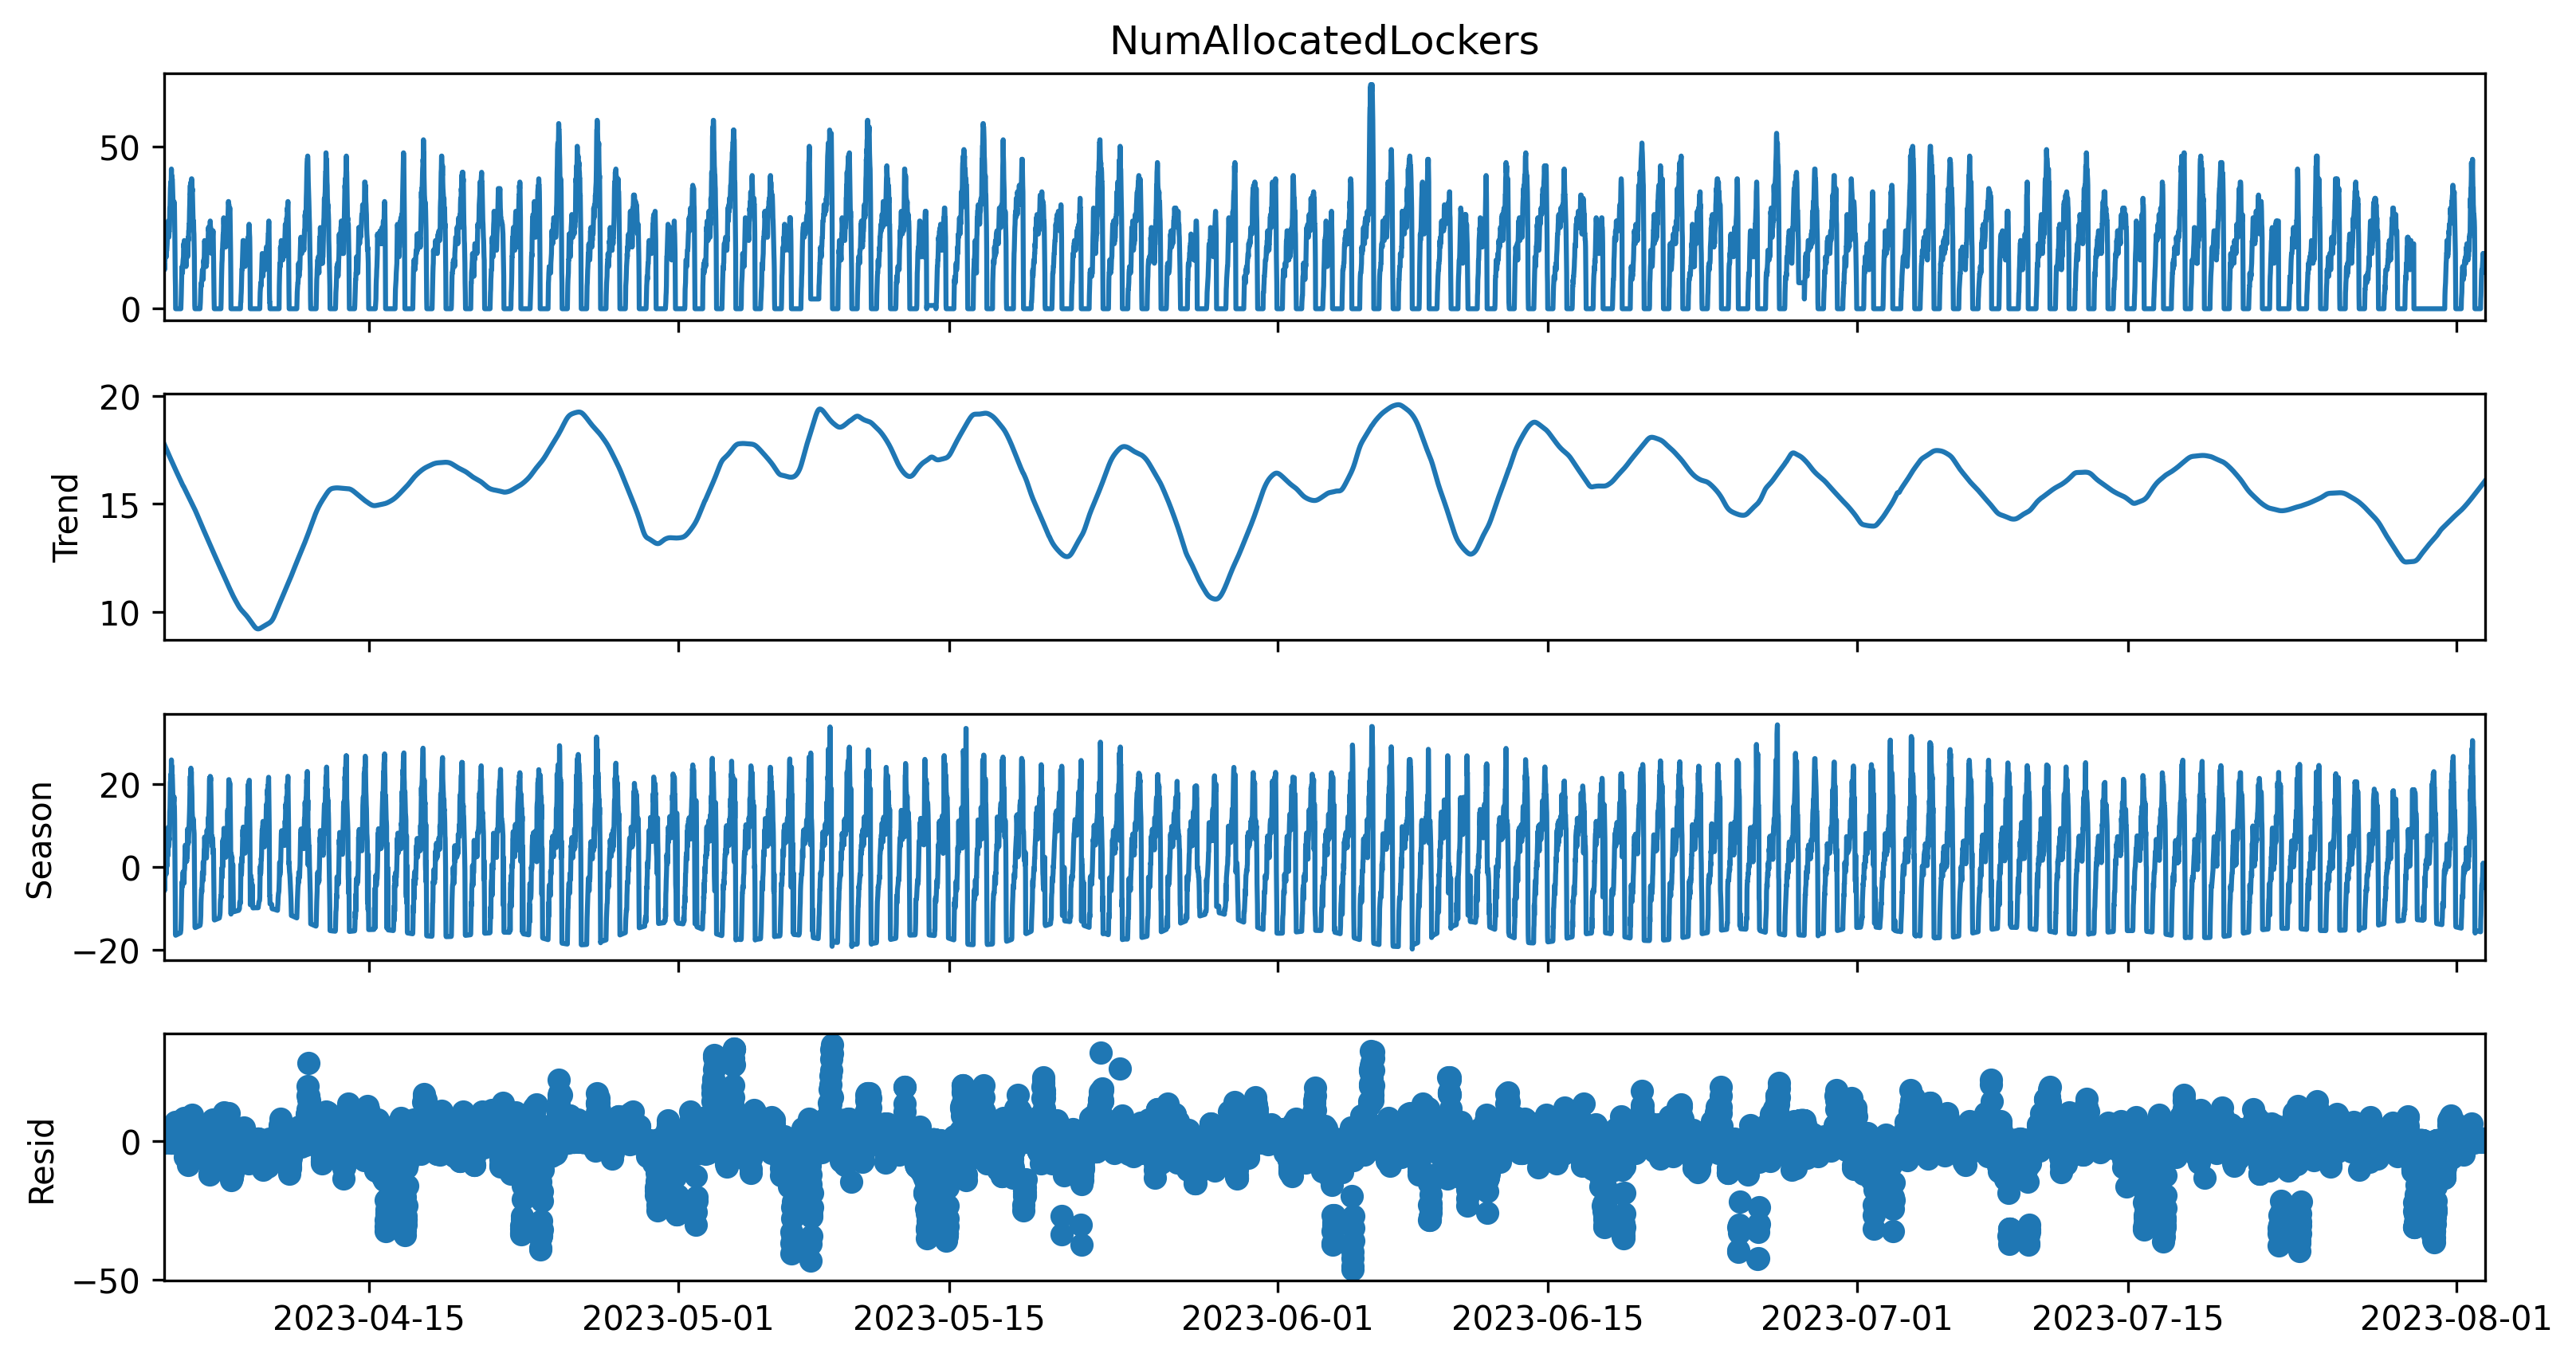

In [43]:
fig = res.plot()
fig.set_size_inches(12, 6)
fig.set_dpi(300)
print(fig.axes[-1])
fig.show()